In [18]:
import pandas as pd
import geopandas
import pypsa
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy import stats
%matplotlib inline

In [20]:
co2_1990 = 2232e6 # Mt co2 emission in 1990
rate = 0.02 # inflation rate

sns.set_style("ticks")
figsize=(12.8,8)
fs = 20
mew = 3
ms = 15
lw = 3
color_cf = 'r'
color_pene = 'w'
dict_rename_gas = {'gas boiler':'gas','CHP':'gas','CCGT':'gas','CHP heat':'gas'}
# dict_rename_solar = {'solar':'solar PV'}
# dict_rename_pth = {'heat pump':'HP', 'resistive heater':'RH'}

import yaml
with open('config.yaml') as f:
    config = yaml.load(f,Loader=yaml.FullLoader)
    tech_colors = config['plotting']['tech_colors']

In [21]:
def rename_techs(label):
    if label[:8] == "central ":
        label = label[8:]
    if label[:6] == "urban ":
        label = label[6:]

    if "retrofitting" in label:
        label = "building retrofitting"
    if "H2" in label:
        label = "hydrogen storage"
    if "CHP" in label:
        label = "CHP"
    if "water tank" in label:
        label = "water tanks"
    if label=="water tanks":
        label = "hot water storage"
    if "OCGT" in label:
        label = "gas"
    if "gas" in label and label != "gas boiler" and label != "gas cooler":
        label = "gas"
    if "nuclear" in label:
        label = "nuclear"
    if "lignite" in label:
        label = "lignite"
    if "coal" in label:
        label = "coal"
    if "solar thermal" in label:
        label = "solar thermal"
    if label == "oil Store":
        label = "oil"
    if label == "solar":
        label = "solar PV"
    if "heat pump" in label:
        label = "heat pump"
    if label == "Sabatier":
        label = "methanation"
    if label == "offwind":
        label = "offshore wind"
    if label == "onwind":
        label = "onshore wind"
    if label == "ror":
        label = "hydroelectricity"
    if label == "hydro":
        label = "hydroelectricity"
    if label == "PHS":
        label = "hydroelectricity"
    if "battery" in label:
        label = "battery storage"

    return label

In [22]:
d = {'gas':0.187,
     'coal':0.354,
     'lignite':0.334,
     'oil':0.248,
    }
co2_intensity = pd.Series(d)

In [23]:
csvs = {}
csvs['costs'] = pd.read_csv('../results/csvs/costs.csv',index_col=[0,1,2],header=[0,2])
csvs['energy'] = pd.read_csv('../results/csvs/energy.csv',index_col=[0,1],header=[0,2])
csvs['supply'] = pd.read_csv('../results/csvs/supply.csv',index_col=[0,1,2],header=[0,2])
csvs['metrics'] = pd.read_csv('../results/csvs/metrics.csv',index_col=0,header=[0,2])

In [24]:
df = csvs['energy']

total_demand = -df.loc['loads',('go','2020')].sum()

df = df.loc['stores'].rename(mapper=rename_techs)

df = df.groupby(df.index).sum()

df = df.reindex(index=co2_intensity.index)

s_emi = df.multiply(co2_intensity,axis=0).sum()

s_emi = s_emi/co2_1990

s_uti = s_emi

In [25]:
df = csvs['costs']

s = df.sum()
s_n = s.divide((1+rate)**(s.index.get_level_values(1).astype(int)-2020))
s_n = (s_n.groupby('scenario').sum()*5/1e9).astype(int)

to_drop = df.index[df.max(axis=1) < 1]

df = df.drop(to_drop)
df = df.droplevel(0)
df.rename(level=1,mapper=rename_techs,inplace=True)

df_cc = df.droplevel(0).groupby(level=0).sum()/total_demand
df_cc = df_cc.rename(dict_rename_gas)
df_cc = df_cc.groupby(by=df_cc.index).sum()
df_cc = df_cc.reindex(['lignite','coal', 'gas', 'nuclear',
                       'heat pump', 'resistive heater','methanation', 
                       'hot water storage', 'hydroelectricity', 'hydrogen storage',
                       'offshore wind', 'onshore wind',  'solar PV',
                       'transmission lines'])

df_mc = df.loc['marginal'].groupby(level=0).sum()/total_demand
df_mc = df_mc.reindex(['lignite','coal', 'gas','nuclear'])

In [26]:
df = csvs['metrics'].filter(like='uti',axis=0)
df.rename(lambda x:x[:-4],inplace=True)
df = df.rename(dict_rename_gas).groupby(level=0).mean()
df = df.reindex(df_mc.index)
df_uti = df.loc['gas']

/home/kun/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [27]:
df_ex = csvs['metrics'].filter(like='expansion',axis=0)
df_ex = df_ex.rename(lambda x:x[:-10])/1e3/5 # GW per year
df_ex.rename(mapper=rename_techs,inplace=True)
df_ex = df_ex.rename(dict_rename_gas)
df_ex = df_ex.groupby(df_ex.index).sum()
df_ex = df_ex.reindex(['lignite','coal', 'gas', 'nuclear',
                       'heat pump', 'resistive heater',
                       'hot water storage', 'hydrogen storage',
                       'offshore wind', 'onshore wind',  'solar PV'])

renewable = ['onshore wind','offshore wind','solar PV']
conventional = ['lignite','coal','gas','oil','nuclear']
pth = ['heat pump','resistive heater']
store = ['battery storage','hydrogen storage','hot water storage']
s_tr = csvs['metrics'].loc['transmission volume']

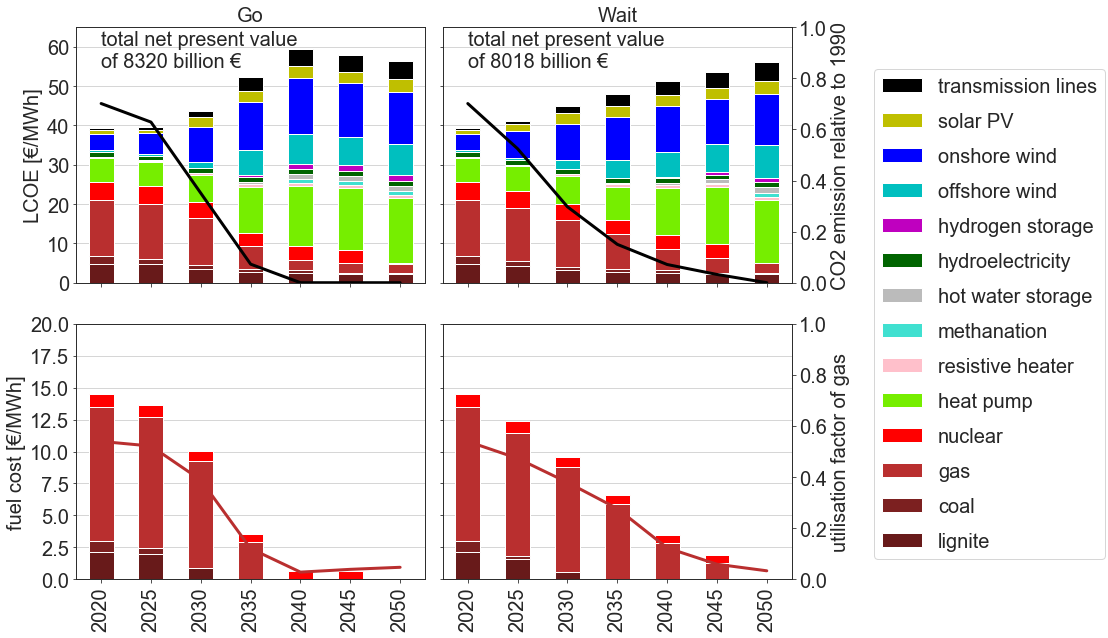

In [28]:
fig, axes = plt.subplots(2,2,figsize=(12,9),sharex=True,sharey='row')

ax = axes[0][0]
df = df_cc['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_ylim([0,65])
ax.set_ylabel("LCOE [€/MWh]",fontsize=fs)
ax.set_title('Go',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present value \nof {} billion €'.format(s_n['go']),xy=(0,55),fontsize=fs)
ax_twin = ax.twinx()
s_emi['go'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
ax_twin.set_ylim([0,1])
ax_twin.set_yticks([])

ax = axes[0][1]
df = df_cc['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
handles,labels = ax.get_legend_handles_labels()

ax.set_title('Wait',fontsize=fs)
ax.grid('on',axis='y')
ax.annotate('total net present value \nof {} billion €'.format(s_n['wait']),xy=(0,55),fontsize=fs)
ax_twin = ax.twinx()
s_emi['wait'].plot(ax=ax_twin,fontsize=fs,color='k',lw=lw)
ax_twin.set_ylim([0,1])
ax_twin.set_ylabel("CO2 emission relative to 1990",fontsize=fs)

ax = axes[1][0]
df = df_mc['go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_ylim([0,65])
ax.set_xlabel("")
ax.set_ylabel("fuel cost [€/MWh]",fontsize=fs)
ax.set_ylim([0,20])
ax.grid('on',axis='y')
ax_twin = ax.twinx()
s = df_uti['go']
s.plot(ax=ax_twin,fontsize=fs,color=tech_colors[s.name],lw=lw,legend=False)
ax_twin.set_ylim([0,1])
ax_twin.set_yticks([])

ax = axes[1][1]
ax_twin = ax.twinx()
s = df_uti['wait']
s.plot(ax=ax_twin,fontsize=fs,color=tech_colors[s.name],lw=lw,legend=False)
ax_twin.set_ylim([0,1])
ax_twin.set_ylabel("utilisation factor of gas",fontsize=fs)
df = df_mc['wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_xlabel("")
ax.grid('on',axis='y')

handles.reverse()
labels.reverse()
fig.legend(handles,labels,ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/system_cost.png',dpi=300, bbox_inches='tight')

In [29]:
fig, axes = plt.subplots(2,2,figsize=(12,9),sharex=True,sharey='row')

ax = axes[0][0]
df = df_ex.loc[renewable+conventional,'go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_ylabel("generator power capacity [GW/a]",fontsize=fs)
ax.set_title('Go',fontsize=fs)
ax.grid('on',axis='y')
ax_twin = ax.twinx()
df = df_ex.loc[store,'go']/1e3
df.T.plot(ax=ax_twin,fontsize=fs,color=[tech_colors[i] for i in df.index],lw=lw,legend=False)
ax_twin.set_ylim([0,15])
ax_twin.set_yticks([])

ax = axes[0][1]
df = df_ex.loc[renewable+conventional,'wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_title('Wait',fontsize=fs)
ax.grid('on',axis='y')
ax_twin = ax.twinx()
df = df_ex.loc[store,'wait']/1e3
df.T.plot(ax=ax_twin,fontsize=fs,color=[tech_colors[i] for i in df.index],lw=lw,legend=False)
ax_twin.set_ylim([0,15])
ax_twin.set_ylabel("storage energy capacity (TWh/a)",fontsize=fs)
handles1,labels1 = ax.get_legend_handles_labels()

ax = axes[1][0]
df = df_ex.loc[pth,'go']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_ylabel("PtH power capacity [GW/a]",fontsize=fs)
ax.set_xlabel("")
ax.grid('on',axis='y')
ax_twin = ax.twinx()
s = s_tr['go']
s = pd.Series(index=s.index,data=s.values-np.insert(s.values[:6],0,0))
s.plot(ax=ax_twin,fontsize=fs,color='k',lw=lw,legend=False)
ax_twin.set_ylim([0,200])
ax_twin.set_yticks([])

ax = axes[1][1]
ax_twin = ax.twinx()
s = s_tr['wait']
s = pd.Series(index=s.index,data=s.values-np.insert(s.values[:6],0,0))
s.plot(ax=ax_twin,fontsize=fs,color='k',lw=lw,legend=False)
ax_twin.set_ylim([0,200])
ax_twin.set_ylabel("transmission volume (TWkm/a)",fontsize=fs)
df = df_ex.loc[pth,'wait']
df.T.plot(kind="bar",ax=ax,stacked=True,color=[tech_colors[i] for i in df.index],legend=False,fontsize=fs)
ax.set_xlabel("")
ax.grid('on',axis='y')

handles2,labels2 = ax.get_legend_handles_labels()
handles = handles1+handles2
labels = labels1+labels2
fig.legend(handles,labels,ncol=1,loc="center left",fontsize=20,bbox_to_anchor=[1,0.5],labelspacing=0.8)

fig.tight_layout()

plt.savefig('../../figures/expansion.png',dpi=300, bbox_inches='tight')